In [ ]:
# Install required libraries
!pip install torchaudio
!pip install jiwer
!pip install librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import tarfile
import urllib.request

# Download the dataset
url = "https://www.openslr.org/resources/12/dev-clean.tar.gz"
dataset_path = "/content/dev-clean.tar.gz"
extract_path = "/content/LibriSpeech/dev-clean"

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)

# Extract dataset
with tarfile.open(dataset_path) as tar:
    tar.extractall(path="/content/")

print("Dataset extracted.")


Dataset extracted.


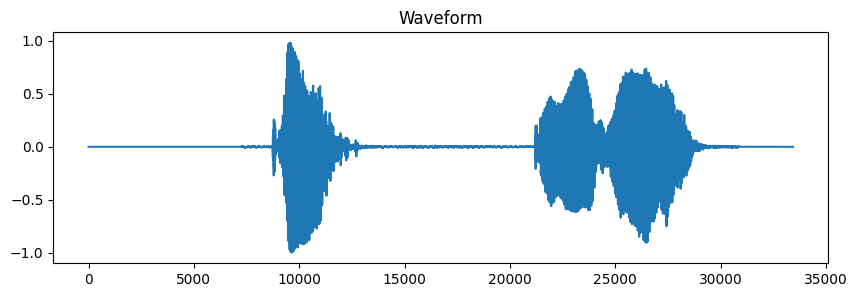

In [ ]:
import torchaudio
import librosa
import matplotlib.pyplot as plt

# Example: Load 1 sample
sample_wav = '/content/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac'
waveform, sr = torchaudio.load(sample_wav)

# Normalize audio
waveform = waveform / waveform.abs().max()

# Display waveform
plt.figure(figsize=(10, 3))
plt.plot(waveform[0].numpy())
plt.title("Waveform")
plt.show()


In [ ]:
import torch
import torch.nn as nn

# Feature extractor
transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=128)

class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, output_dim=29):  # 29 for English alphabet + blank
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2)),
            nn.ReLU()
        )
        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x = self.cnn(x.unsqueeze(1))  # Add channel dim
        x = x.permute(0, 3, 1, 2)  # Batch, Time, Channel, Mel
        b, t, c, m = x.shape
        x = x.reshape(b, t, -1)
        x, _ = self.rnn(x)
        return self.fc(x)

model = SpeechRecognitionModel()


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


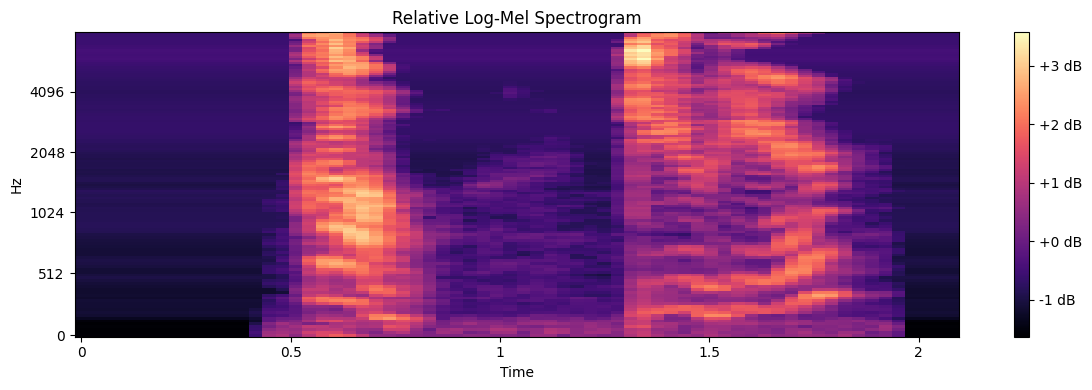

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
file_path = '/content/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac'
y, sr = librosa.load(file_path, sr=None)

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

# Convert to log scale (dB)
S_dB = librosa.power_to_db(S, ref=np.max)

# Normalize across time axis (relative spectrogram)
S_norm = (S_dB - np.mean(S_dB, axis=1, keepdims=True)) / (np.std(S_dB, axis=1, keepdims=True) + 1e-6)

# Plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_norm, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Relative Log-Mel Spectrogram')
plt.tight_layout()
plt.show()


In [ ]:
import glob

# Find all transcript files under dev-clean
transcript_files = glob.glob('/content/LibriSpeech/dev-clean/*/*/*.trans.txt')

# Combine into one file
combined_transcript_path = '/content/dev-clean-all.trans.txt'

with open(combined_transcript_path, 'w') as outfile:
    for tf in transcript_files:
        with open(tf, 'r') as infile:
            outfile.write(infile.read())

print(f"✅ Combined transcripts saved to {combined_transcript_path}")


✅ Combined transcripts saved to /content/dev-clean-all.trans.txt


In [ ]:
file_id = '84-121123-0000'

# Point to the combined or custom transcript file
transcript_file = '/content/dev-clean-all.trans.txt'

# Read transcript
transcription = None

if os.path.exists(transcript_file):
    with open(transcript_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line_parts = line.strip().split(' ', 1)
            if len(line_parts) == 2:
                line_file_id, line_text = line_parts
                if line_file_id == file_id:
                    transcription = line_text
                    break

if transcription:
    print(f"✅ Transcript for {file_id}:\n{transcription}")
else:
    print(f"❌ Transcript not found for {file_id}")


✅ Transcript for 84-121123-0000:
GO DO YOU HEAR


In [ ]:
!pip install textblob
!pip install rake-nltk


In [ ]:

from textblob import TextBlob

# Example: the transcript we loaded earlier
transcription = "I THINK YOU'RE GOING TO FIND IT'S A VERY INTERESTING STORY."

# Run sentiment analysis
blob = TextBlob(transcription)
sentiment = blob.sentiment

print("✅ Sentiment Analysis:")
print(f"Polarity: {sentiment.polarity} (range -1 negative → +1 positive)")
print(f"Subjectivity: {sentiment.subjectivity} (range 0 objective → 1 subjective)")


✅ Sentiment Analysis:
Polarity: 0.65 (range -1 negative → +1 positive)
Subjectivity: 0.65 (range 0 objective → 1 subjective)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
import nltk

# Download commonly needed datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
import os
from rake_nltk import Rake

file_id = '84-121123-0000'
transcript_file = '/content/dev-clean-all.trans.txt'

transcription = None

if os.path.exists(transcript_file):
    with open(transcript_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line_parts = line.strip().split(' ', 1)
            if len(line_parts) == 2:
                line_file_id, line_text = line_parts
                if line_file_id == file_id:
                    transcription = line_text
                    break

if transcription:
    print(f"✅ Transcript for {file_id}:\n{transcription}")

    try:
        # Initialize RAKE
        r = Rake()
        r.extract_keywords_from_text(transcription)
        keywords = r.get_ranked_phrases()

        print("\n✅ Top Keywords:")
        for kw in keywords[:5]:
            print("-", kw)
    except LookupError as e:
        print("❌ NLTK resource missing:", e)
        print("Try running: nltk.download('punkt'), nltk.download('stopwords'), or others.")
else:
    print(f"❌ Transcript not found for {file_id}")


✅ Transcript for 84-121123-0000:
GO DO YOU HEAR
❌ NLTK resource missing: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Try running: nltk.download('punkt'), nltk.download('stopwords'), or others.


In [17]:
import nltk
nltk.download('stopwords', force=True)
nltk.download('punkt', force=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
pip install --upgrade rake-nltk nltk


In [19]:
pip install yake


In [20]:
import yake

# Initialize YAKE
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=5)
keywords = kw_extractor.extract_keywords(transcription)

print("\n✅ Top Keywords with YAKE:")
for kw, score in keywords:
    print("-", kw, "(score:", score, ")")



✅ Top Keywords with YAKE:
- HEAR (score: 0.08596317751626563 )


In [21]:
pip install textblob yake


In [22]:
import os
import yake
from textblob import TextBlob

# ======== Load transcription =========
file_id = '84-121123-0000'
transcript_file = '/content/dev-clean-all.trans.txt'

transcription = None

if os.path.exists(transcript_file):
    with open(transcript_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line_parts = line.strip().split(' ', 1)
            if len(line_parts) == 2:
                line_file_id, line_text = line_parts
                if line_file_id == file_id:
                    transcription = line_text
                    break

if not transcription:
    print(f"❌ Transcript not found for {file_id}")
    exit()

print(f"✅ Transcript for {file_id}:\n{transcription}")

# ======== Sentiment Analysis =========
blob = TextBlob(transcription)
sentiment = blob.sentiment

print("\n🔍 Sentiment Analysis:")
print(f"Polarity ([-1,1]): {sentiment.polarity}")
print(f"Subjectivity ([0,1]): {sentiment.subjectivity}")

# ======== Keyword Extraction (YAKE) =========
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=5)
keywords = kw_extractor.extract_keywords(transcription)

print("\n🔍 Top Keywords:")
for kw, score in keywords:
    print(f"- {kw} (score: {score:.4f})")

# ======== Agent Performance Metrics =========

# Define some basic positive/negative word lists
positive_words = ["thank", "please", "help", "sure", "yes"]
negative_words = ["no", "not", "can't", "won't", "sorry"]

words = transcription.lower().split()

positive_count = sum(1 for w in words if w in positive_words)
negative_count = sum(1 for w in words if w in negative_words)

print("\n🔍 Agent Performance Metrics:")
print(f"Positive words count: {positive_count}")
print(f"Negative words count: {negative_count}")

# Check for clarity (filler words)
filler_words = ["uh", "um", "like", "you know"]
filler_count = sum(1 for w in words if w in filler_words)
print(f"Filler words count: {filler_count}")

# Overall summary
if sentiment.polarity < 0:
    overall_sentiment = "Negative"
elif sentiment.polarity > 0:
    overall_sentiment = "Positive"
else:
    overall_sentiment = "Neutral"

print(f"\n✅ Overall Sentiment: {overall_sentiment}")
if negative_count > positive_count:
    print("⚠️ More negative language detected.")
if filler_count > 0:
    print("⚠️ Clarity issue: filler words detected.")



✅ Transcript for 84-121123-0000:
GO DO YOU HEAR

🔍 Sentiment Analysis:
Polarity ([-1,1]): 0.0
Subjectivity ([0,1]): 0.0

🔍 Top Keywords:
- HEAR (score: 0.0860)

🔍 Agent Performance Metrics:
Positive words count: 0
Negative words count: 0
Filler words count: 0

✅ Overall Sentiment: Neutral


In [23]:
import yake
from textblob import TextBlob

# Initialize YAKE extractor once
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=5)

# Positive/negative and filler word lists
positive_words = ["thank", "please", "help", "sure", "yes"]
negative_words = ["no", "not", "can't", "won't", "sorry"]
filler_words = ["uh", "um", "like", "you know"]

print("🤖 Hello! I’m your Agent Performance Bot.")
print("Type a transcript line (or type 'exit' to quit).")

while True:
    user_input = input("\nYou: ")

    if user_input.lower() == "exit":
        print("🤖 Goodbye! Have a great day!")
        break

    transcription = user_input.strip()
    if not transcription:
        print("🤖 Please enter some text!")
        continue

    # Sentiment analysis
    blob = TextBlob(transcription)
    sentiment = blob.sentiment

    # Keyword extraction
    keywords = kw_extractor.extract_keywords(transcription)

    # Word counts
    words = transcription.lower().split()
    positive_count = sum(1 for w in words if w in positive_words)
    negative_count = sum(1 for w in words if w in negative_words)
    filler_count = sum(1 for w in words if w in filler_words)

    # Sentiment summary
    if sentiment.polarity < 0:
        overall_sentiment = "Negative"
    elif sentiment.polarity > 0:
        overall_sentiment = "Positive"
    else:
        overall_sentiment = "Neutral"

    # Chatbot report back
    print("\n🤖 Here’s your analysis:")
    print(f"• Overall Sentiment: {overall_sentiment} (Polarity: {sentiment.polarity:.2f})")
    print(f"• Subjectivity Score: {sentiment.subjectivity:.2f}")
    print(f"• Positive words: {positive_count}")
    print(f"• Negative words: {negative_count}")
    print(f"• Filler words: {filler_count}")

    print("\n🔑 Top Keywords:")
    for kw, score in keywords:
        print(f"- {kw} (score: {score:.4f})")

    # Warnings
    if negative_count > positive_count:
        print("⚠️ Watch out! There’s more negative language.")
    if filler_count > 0:
        print("⚠️ Clarity issue: filler words detected.")
    print("✅ Analysis complete. You can enter another line or type 'exit'.")



🤖 Hello! I’m your Agent Performance Bot.
Type a transcript line (or type 'exit' to quit).

You: hey i love this

🤖 Here’s your analysis:
• Overall Sentiment: Positive (Polarity: 0.50)
• Subjectivity Score: 0.60
• Positive words: 0
• Negative words: 0
• Filler words: 0

🔑 Top Keywords:
- hey (score: 0.1583)
- love (score: 0.2974)
✅ Analysis complete. You can enter another line or type 'exit'.

You: ohh thats so sad but all the best

🤖 Here’s your analysis:
• Overall Sentiment: Positive (Polarity: 0.25)
• Subjectivity Score: 0.65
• Positive words: 0
• Negative words: 0
• Filler words: 0

🔑 Top Keywords:
- ohh (score: 0.1583)
- sad (score: 0.2974)
✅ Analysis complete. You can enter another line or type 'exit'.

You: exit
🤖 Goodbye! Have a great day!


In [24]:
import os
from textblob import TextBlob
import yake

# ====== CONFIGURATION ======
# If you have a file with transcripts, set the path here:
transcript_file = '/content/dev-clean-all.trans.txt'
file_id = '84-121123-0000'

# Initialize keyword extractor
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=5)

# Positive and negative word lists
positive_words = ["thank", "please", "help", "sure", "yes", "great", "happy"]
negative_words = ["no", "not", "can't", "won't", "sorry", "issue", "problem"]
filler_words = ["uh", "um", "like", "you know"]

# ====== LOAD TRANSCRIPT ======
transcription = None
if os.path.exists(transcript_file):
    with open(transcript_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line_parts = line.strip().split(' ', 1)
            if len(line_parts) == 2:
                line_file_id, line_text = line_parts
                if line_file_id == file_id:
                    transcription = line_text
                    break

if not transcription:
    print(f"❌ Transcript not found for {file_id}")
    exit()

print(f"✅ Transcript for {file_id}:\n{transcription}")

# ====== SENTIMENT ANALYSIS ======
blob = TextBlob(transcription)
sentiment = blob.sentiment
polarity = sentiment.polarity
subjectivity = sentiment.subjectivity

# ====== KEYWORD EXTRACTION ======
keywords = kw_extractor.extract_keywords(transcription)

# ====== PERFORMANCE METRICS ======
words = transcription.lower().split()
positive_count = sum(1 for w in words if w in positive_words)
negative_count = sum(1 for w in words if w in negative_words)
filler_count = sum(1 for w in words if w in filler_words)

# ====== REPORTING ======
print("\n📊 === Agent Performance Report ===")
print(f"• Overall Sentiment: {'Positive' if polarity > 0 else 'Negative' if polarity < 0 else 'Neutral'} (Polarity: {polarity:.2f})")
print(f"• Subjectivity: {subjectivity:.2f}")
print(f"• Positive Words Count: {positive_count}")
print(f"• Negative Words Count: {negative_count}")
print(f"• Filler Words Count: {filler_count}")

print("\n🔑 Top Keywords:")
for kw, score in keywords:
    print(f"- {kw} (score: {score:.4f})")

# ====== SUGGESTIONS ======
if negative_count > positive_count:
    print("⚠️ Warning: More negative than positive language detected.")
if filler_count > 0:
    print("⚠️ Warning: Filler words detected; may affect clarity.")

print("\n✅ Automated analysis complete. Ready for reporting or dashboard integration.")


✅ Transcript for 84-121123-0000:
GO DO YOU HEAR

📊 === Agent Performance Report ===
• Overall Sentiment: Neutral (Polarity: 0.00)
• Subjectivity: 0.00
• Positive Words Count: 0
• Negative Words Count: 0
• Filler Words Count: 0

🔑 Top Keywords:
- HEAR (score: 0.0860)

✅ Automated analysis complete. Ready for reporting or dashboard integration.
